# Linear case

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
import tqdm
from IPython.display import display, Math
import corner
import emcee
import MH_MCMC
np.random.seed(12345)

plt.rcParams['figure.dpi'] = 200

## Fake linear data

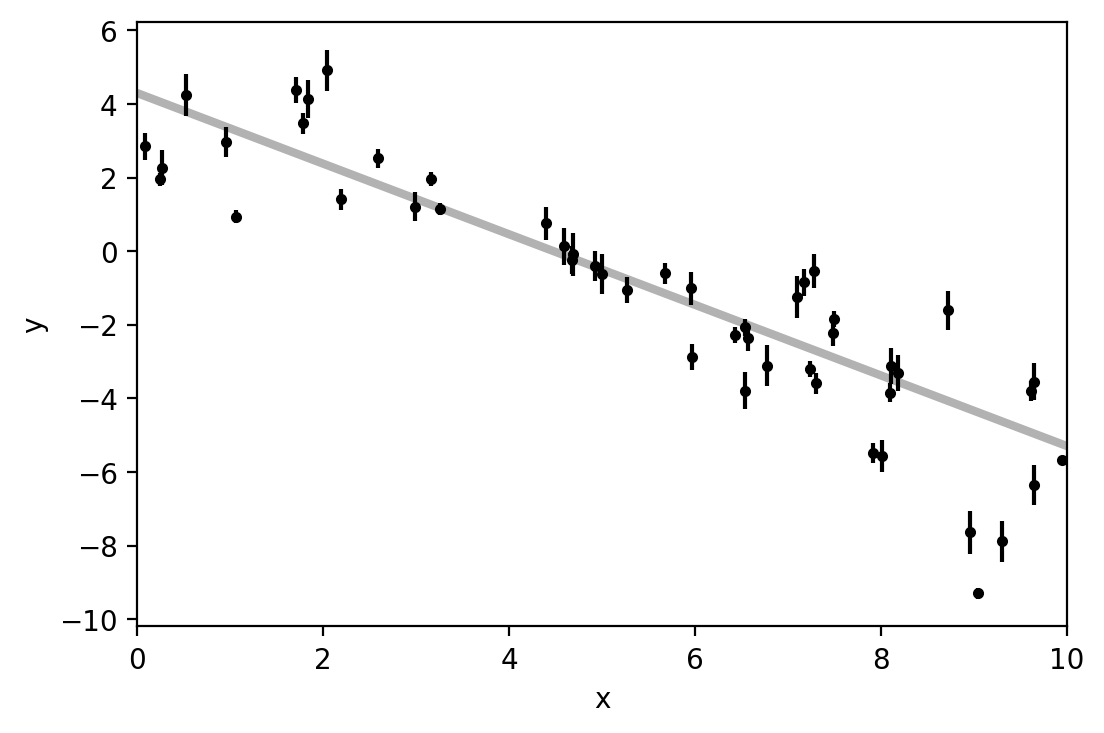

In [25]:
# linear data I biult

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y)* np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Simplest Metropolis-Hasting Sampler
Here I use a normal distribution with given sigma to choose the step in proposal 

In [26]:
# model definition: linear
def modelFunction(x, w):
    m, b, log_f = w
    return m * x + b

In [27]:
# likelyhood function
def logLikelihood(w, x, y, yerr):
    m, b, log_f = w
    model = modelFunction(x, w)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [28]:
# Prior distribution: only give a limitation range here
def logPrior(w,wrange):
    #m, b, log_f = w
    for i in range(len(w)):
        if (w[i] < wRange[i,0]) or (w[i] > wRange[i,1]):
            return -np.inf
    return 0.0

In [29]:
# Prob = Prior * Likelyhood
def log_probability(w, x, y, yerr):
    lp = logPrior(w,wrange)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(w, x, y, yerr)

In [30]:
# give initial values of parameters
def samplePrior():
    nParams = wRange.shape[0] # the number of parameters
    w = np.zeros(nParams)
    for i in range(nParams):
        w[i] = (wRange[i,1]-wRange[i,0])* np.random.rand() + wRange[i,0] # randomly choose a value in the acceptable range
    
    return w

In [31]:
# how to walk in parameter space for each step
def propose(w, sigma):
    nParam = len(w)
    wNew = np.zeros_like(w, dtype=np.float64)
    wNew[:] = w

    # Which one should we change? only one parameter changes in each step
    i = int(np.random.rand()*nParam)
    wNew[i] += stats.norm(0, sigma).rvs()
        
    return wNew

In [32]:
# main function for MCMC
def MCMC(Nsteps, data, wrange,sigma):
    x, y, yerr = data

    # start off at some random w drawn from our prior distribution
    w = samplePrior()
    logp, logl = logPrior(w,wrange), logLikelihood(w,x, y, yerr)

    nParam = w.shape[0] # the value of w plus its likelihood
    chain = np.zeros((Nsteps, nParam + 1))

    # count the number of successful proposals
    ngood = 0

    for i in tqdm.tqdm_notebook(range(Nsteps)):
        wNew = propose(w,sigma)
        logpNew = logPrior(wNew,wrange)

        # Only evaluate the likelihood if prior prob isn't zero
        loglNew = -np.Inf
        if logpNew != -np.Inf:
            loglNew = logLikelihood(wNew,x, y, yerr)

        # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
        logRatio = (logpNew + loglNew) - (logp + logl)
        logRatio = min(0.0, logRatio)

        # Acceptance/rejection
        if np.random.rand() <= np.exp(logRatio):
            w = wNew
            logp = logpNew
            logl = loglNew
            ngood += 1

        chain[i, :-1] = w
        chain[i, -1] = logl
    return chain, ngood/Nsteps

In [33]:
# the number of steps
N = 10**5

# our data
data = [x,y,yerr]

# Ranges in parameter values:
wRange = np.array([[-5.,0.5],[0., 10.], [-10., 1.]])

# run MCMC
chain, goodFrac = MCMC(Nsteps = N, data = data,wrange = wRange,sigma=0.1)

print(f"\n\nAcdeptance ratio: {goodFrac}")




Acdeptance ratio: 0.5788


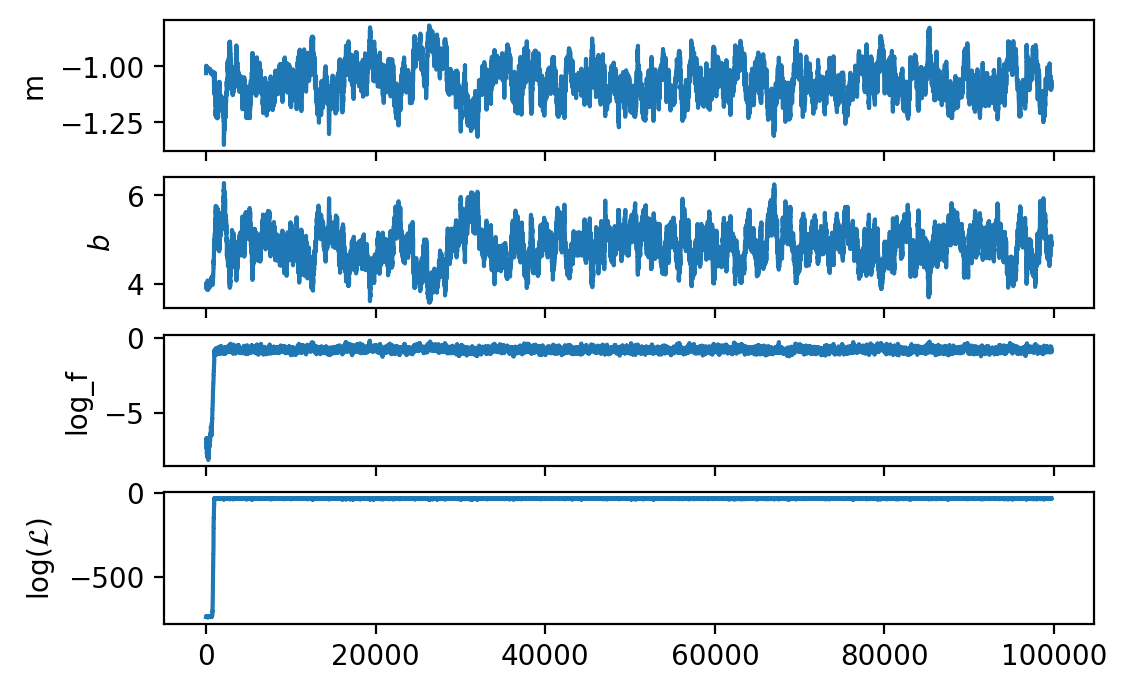

In [34]:
# Have a look on the MC chains 
walker=1
burn=300
end = -1

m  = chain[burn:end,0]
b = chain[burn:end,1]
log_f = chain[burn:end,2]
ll = chain[burn:end,3]


fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(m)
ax[0].set_ylabel(r'm')

ax[1].plot(b)
ax[1].set_ylabel(r'$b$')

ax[2].plot(log_f)
ax[2].set_ylabel(r'log_f')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

samples = chain[burn:,:]

In [35]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
        
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

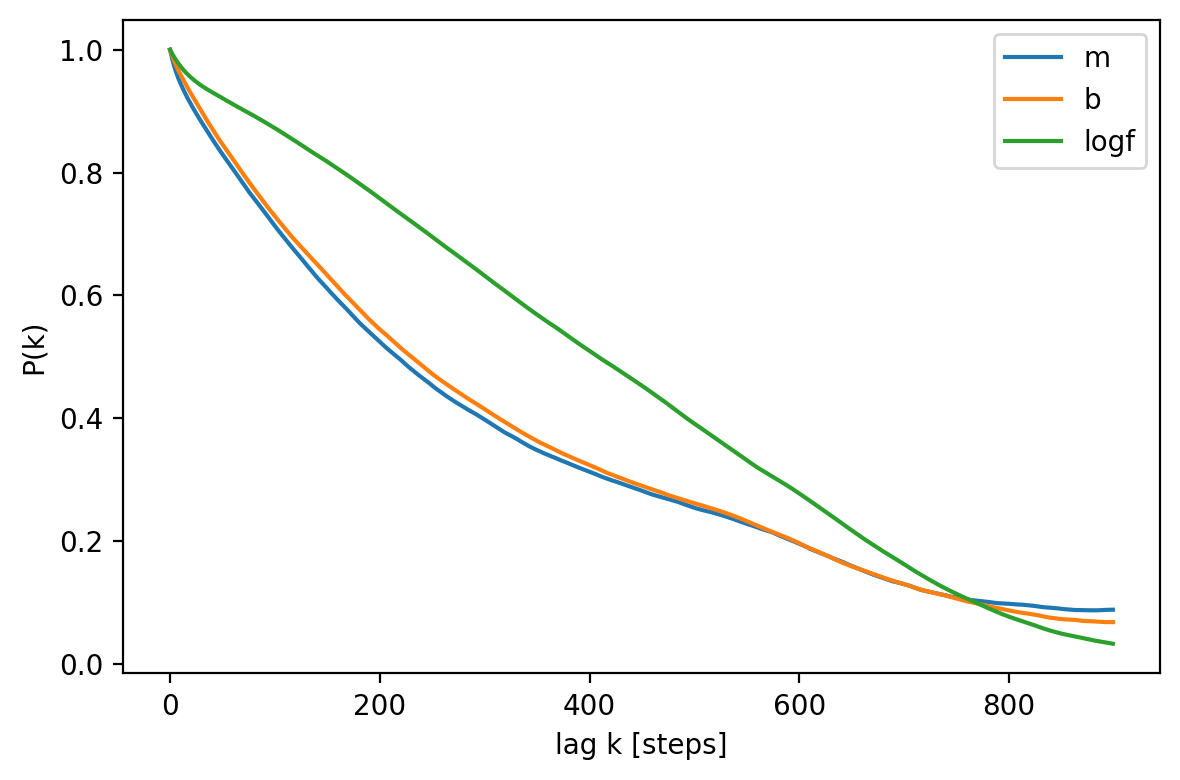

In [36]:
labs = ['m','b','logf']
auto(chain[burn:end,:], nlag=900, labs=labs)

In [37]:
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain_1walker(chain,burn=100, thin=1500):
    Nsteps = len(chain)
    NParams = len(chain[0])
    
    use_walker_chain = chain[burn:,:]

    if thin != False:
        use_chain_point_all = []
        use_len = len(use_walker_chain)
        index = 0
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=thin

        return np.array(use_chain_point_all)
    else:
        return use_walker_chain
        
        

In [38]:
final_chain = flat_chain_1walker(chain,burn=burn, thin=False)
samples = final_chain

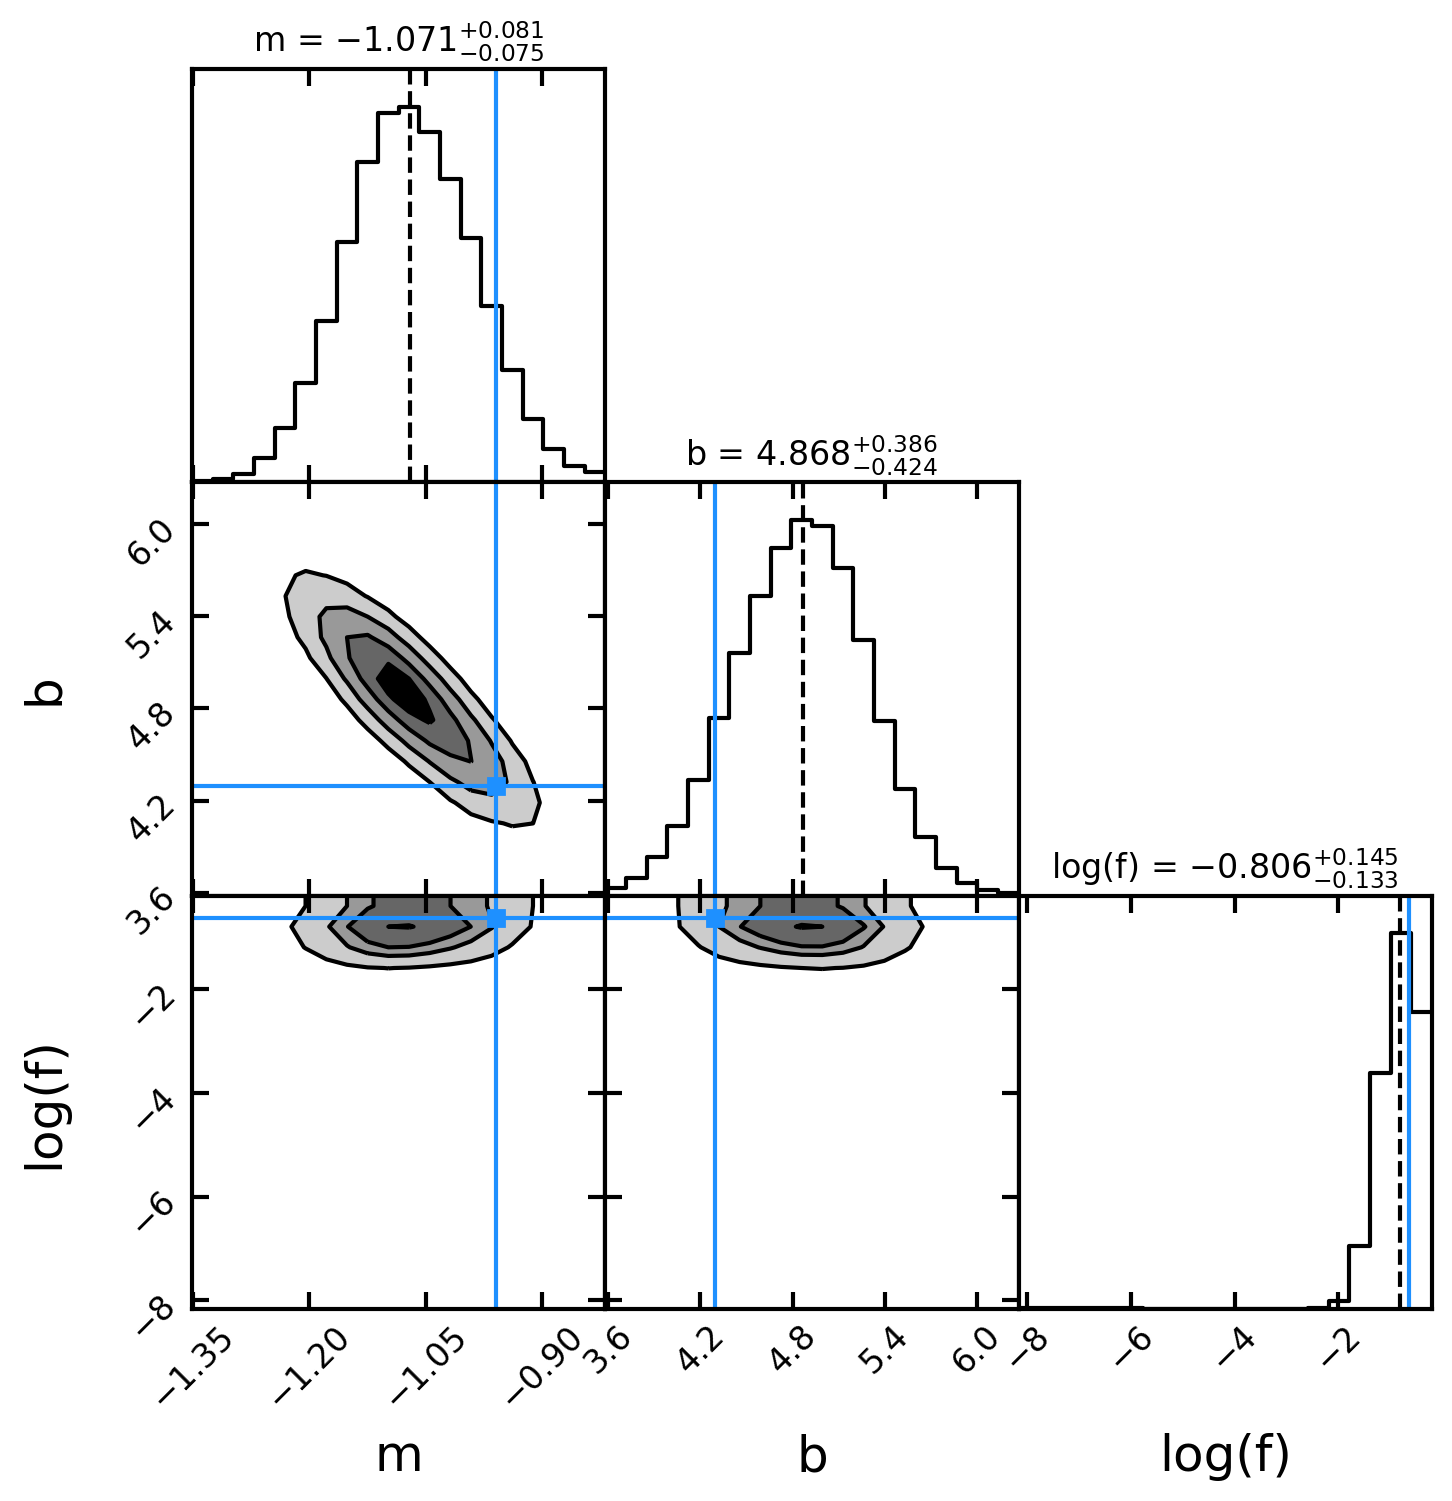

In [39]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


Text(0, 0.5, 'y')

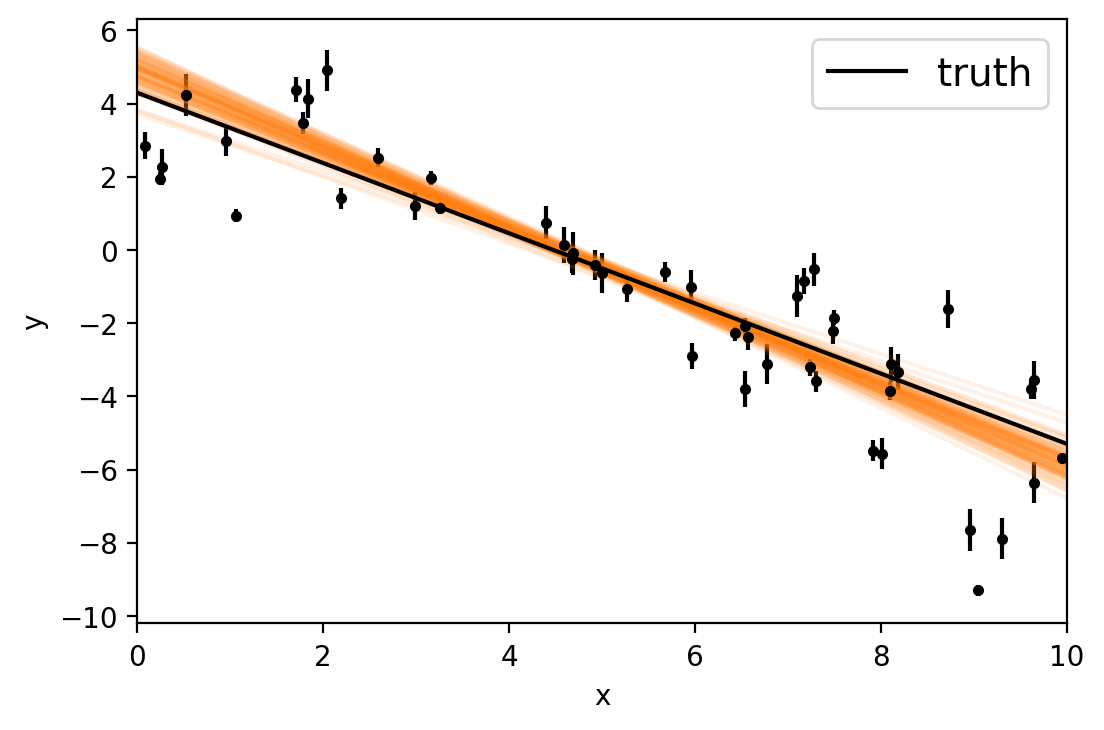

In [40]:
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

# Multiple Indepedent walkers


In [41]:
# main function for MCMC
def MCMC_Nwalker(Nwalkers, Nsteps, data, wrange,sigma):
    total_chain = np.zeros((Nwalkers,Nsteps,4))
    for walker in tqdm.tqdm_notebook(range(Nwalkers)): 
        x, y, yerr = data

        # start off at some random w drawn from our prior distribution
        w = samplePrior()
        logp, logl = logPrior(w,wrange), logLikelihood(w,x, y, yerr)

        nParam = w.shape[0] # the value of w plus its likelihood
        chain = np.zeros((Nsteps, nParam + 1))

        # count the number of successful proposals
        ngood = 0

        for i in tqdm.tqdm_notebook(range(Nsteps)):
            wNew = propose(w,sigma)
            logpNew = logPrior(wNew,wrange)

            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.Inf
            if logpNew != -np.Inf:
                loglNew = logLikelihood(wNew,x, y, yerr)

            # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
            logRatio = (logpNew + loglNew) - (logp + logl)
            logRatio = min(0.0, logRatio)

            # Acceptance/rejection
            if np.random.rand() <= np.exp(logRatio):
                w = wNew
                logp = logpNew
                logl = loglNew
                ngood += 1

            chain[i, :-1] = w
            chain[i, -1] = logl
            total_chain[walker,i,:] = chain[i,:]
    return total_chain, ngood/Nsteps

In [42]:
# the number of steps
N = 10**4

# our data
data = [x,y,yerr]

# Ranges in parameter values:
wRange = np.array([[-5.,0.5],[0., 10.], [-10., 1.]])

# run MCMC
chain, goodFrac = MCMC_Nwalker(Nwalkers = 32, Nsteps = N, data = data,wrange = wRange,sigma=0.1)

print(f"\n\nAcdeptance ratio: {goodFrac}")





Acdeptance ratio: 0.5793


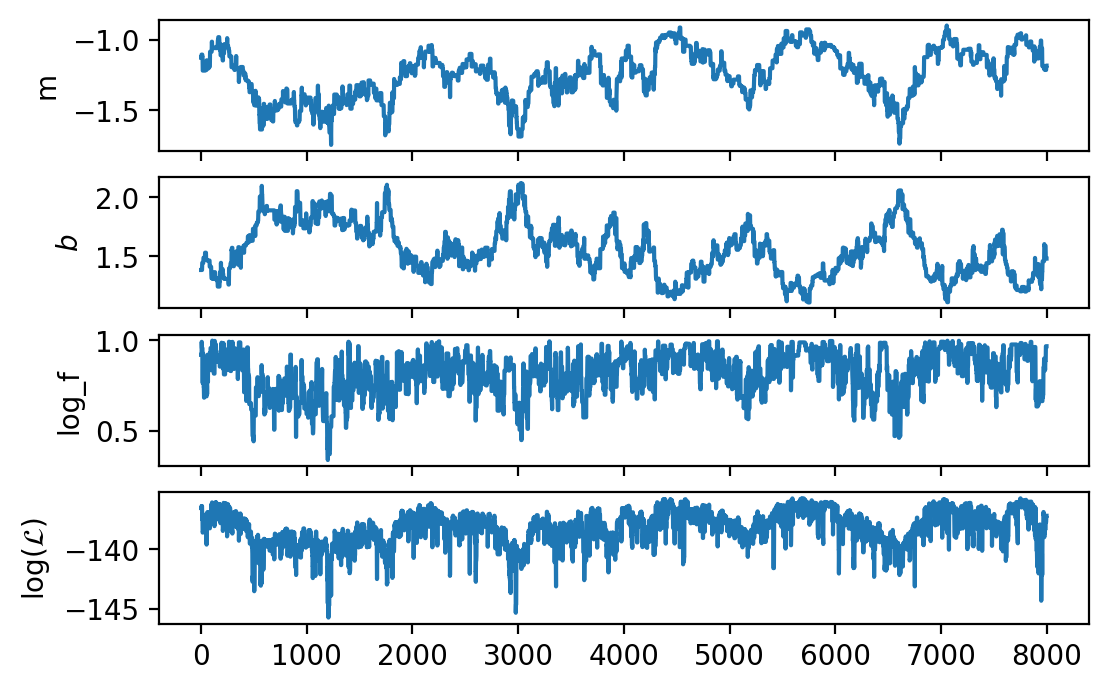

In [43]:
# Have a look on the MC chains 
walker=1
burn=2000
end = -1

m  = chain[walker,burn:end,0]
b = chain[walker,burn:end,1]
log_f = chain[walker,burn:end,2]
ll = chain[walker,burn:end,3]


fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(m)
ax[0].set_ylabel(r'm')

ax[1].plot(b)
ax[1].set_ylabel(r'$b$')

ax[2].plot(log_f)
ax[2].set_ylabel(r'log_f')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

samples = chain[burn:,:]

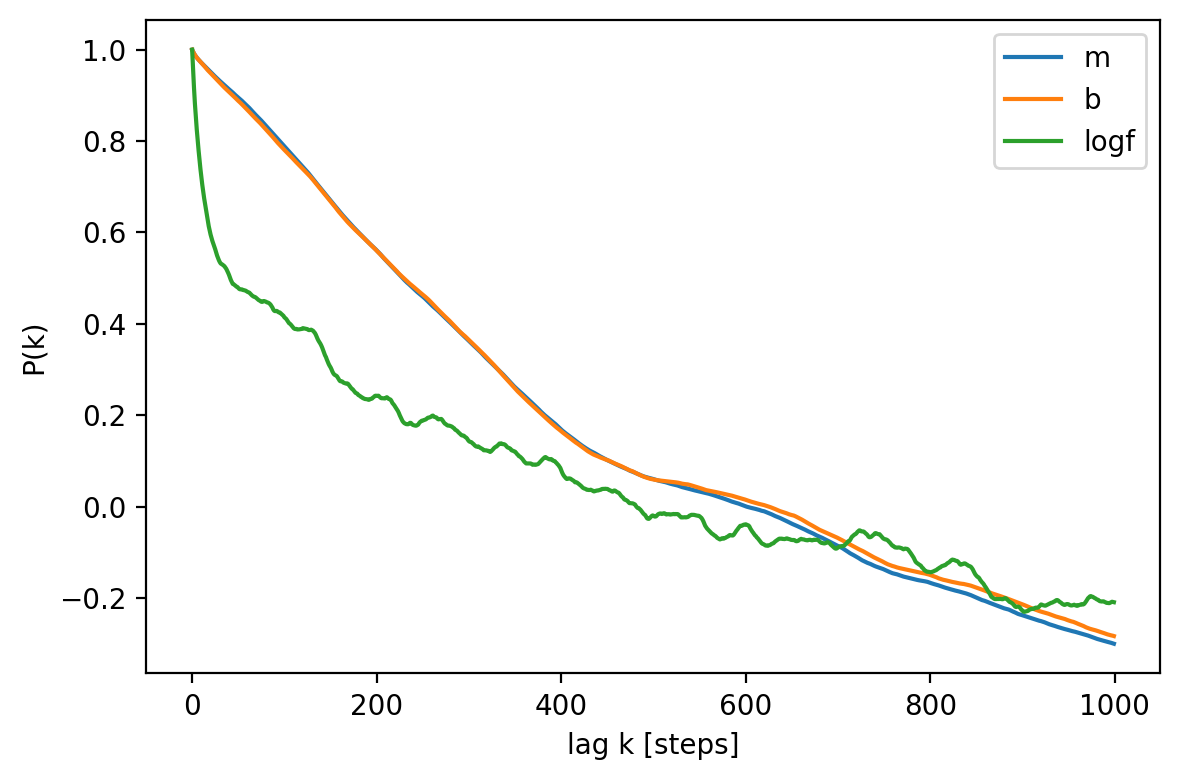

In [44]:
labs = ['m','b','logf']
auto(chain[0,burn:end,:], nlag=1000, labs=labs)

In [45]:
#combine all of chains of walkers
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain(chain,burn=100, thin=1500):
    walker = len(chain)
    Nsteps = len(chain[0])
    NParams = len(chain[0][0])
    print(walker,Nsteps,NParams)
    use_chain_point_all = []
    for i in range(walker):
        use_walker_chain = chain[i,burn:,:]
        use_len = len(use_walker_chain)
        if thin != False:
            index = 0
            while index < use_len:
                use_chain_point_all.append(use_walker_chain[index,:])
                index+=thin
            return np.array(use_chain_point_all)
        else:
            return use_walker_chain
        
        

In [46]:
final_chain = flat_chain(chain,burn=burn, thin=False)
samples = final_chain
len(samples)

32 10000 4


8000

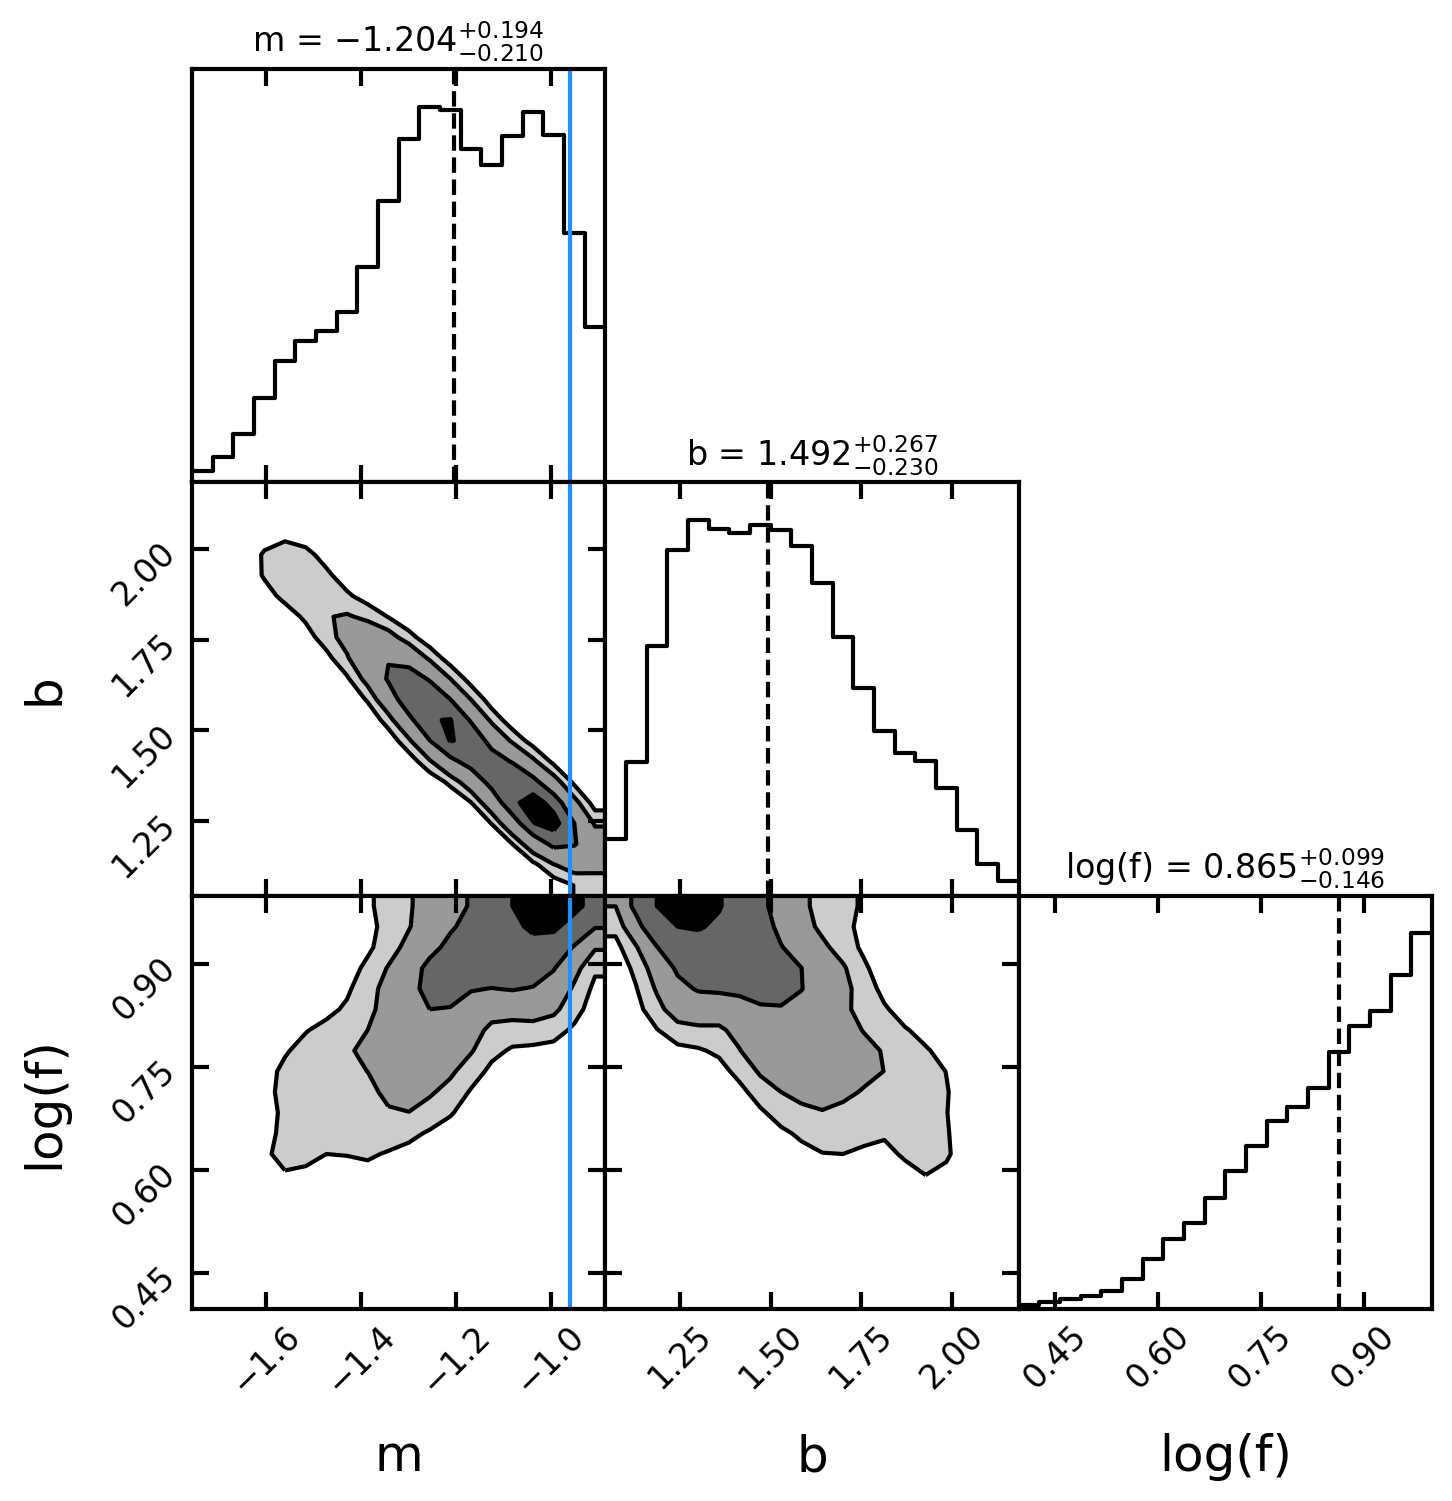

In [47]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


## Adaptive M-H Sampler

only 1 walker

here for each step, all parameters move together, which is proposed from a multivariate normal distribution.

In [48]:
# model definition:
def modelFunction(x, w):
    m, b, log_f = w
    return m * x + b
# prior definition:
def priorFunction(w, wrange):
    for i in range(len(w)):
        if w[i]<wrange[i,0] or w[i]>wrange[i,1]:
            return 0.0
    else:
        return 1.0

In [49]:
# our data
data = [x,y,yerr]

# Ranges in parameter values:
wrange = np.array([[-5.,0.5],[0., 10.], [-10., 1.]],dtype = np.float64)



In [50]:
input_data = np.zeros((len(data[0]),3))
input_data[:,0] = data[0]
input_data[:,1] = data[1]
input_data[:,2] = data[2]

In [51]:
import numba

# begin run adaptive MH MCMC
sigParams = np.array([3.0, 1.0])

labels=['m','b','log_f']
labels = numba.typed.List(labels)

M = MH_MCMC.MCMC(input_data, 3, labels, modelFunction, priorFunction, 
         indivMove=False, solveSigma=True, sigParams=sigParams, seed=12376523)

wStart = np.array([-4.,7.,-1.]) # initial guess
sigStart = np.array([1.,1.,0.1])# inital sigma of parameters

M.sampler(wStart, sigStart, wrange, 200000, 10000, 10000)


In [52]:
def plotChains(M, burn, end):
    n = M.nParam
    nplots = n + 2
    if M.solveSigma:
        nplots += 1
    fig, ax = plt.subplots(nplots,1, figsize=(8,10))
    for i in range(n):
        ax[i].plot(M.chain[burn:end,i])
        ax[i].set_ylabel(M.labels[i])
    if M.solveSigma:
        ax[-3].plot(M.sigmaChain[burn:end])
        ax[-3].set_ylabel('$\sigma$')
    ax[-2].plot(M.logLchain[burn:end])
    ax[-2].set_ylabel('$\log\mathcal{L}$')
    ax[-1].plot(M.acceptRatio[burn:end])
    ax[-1].set_ylabel('acceptance\nratio')
    plt.tight_layout();

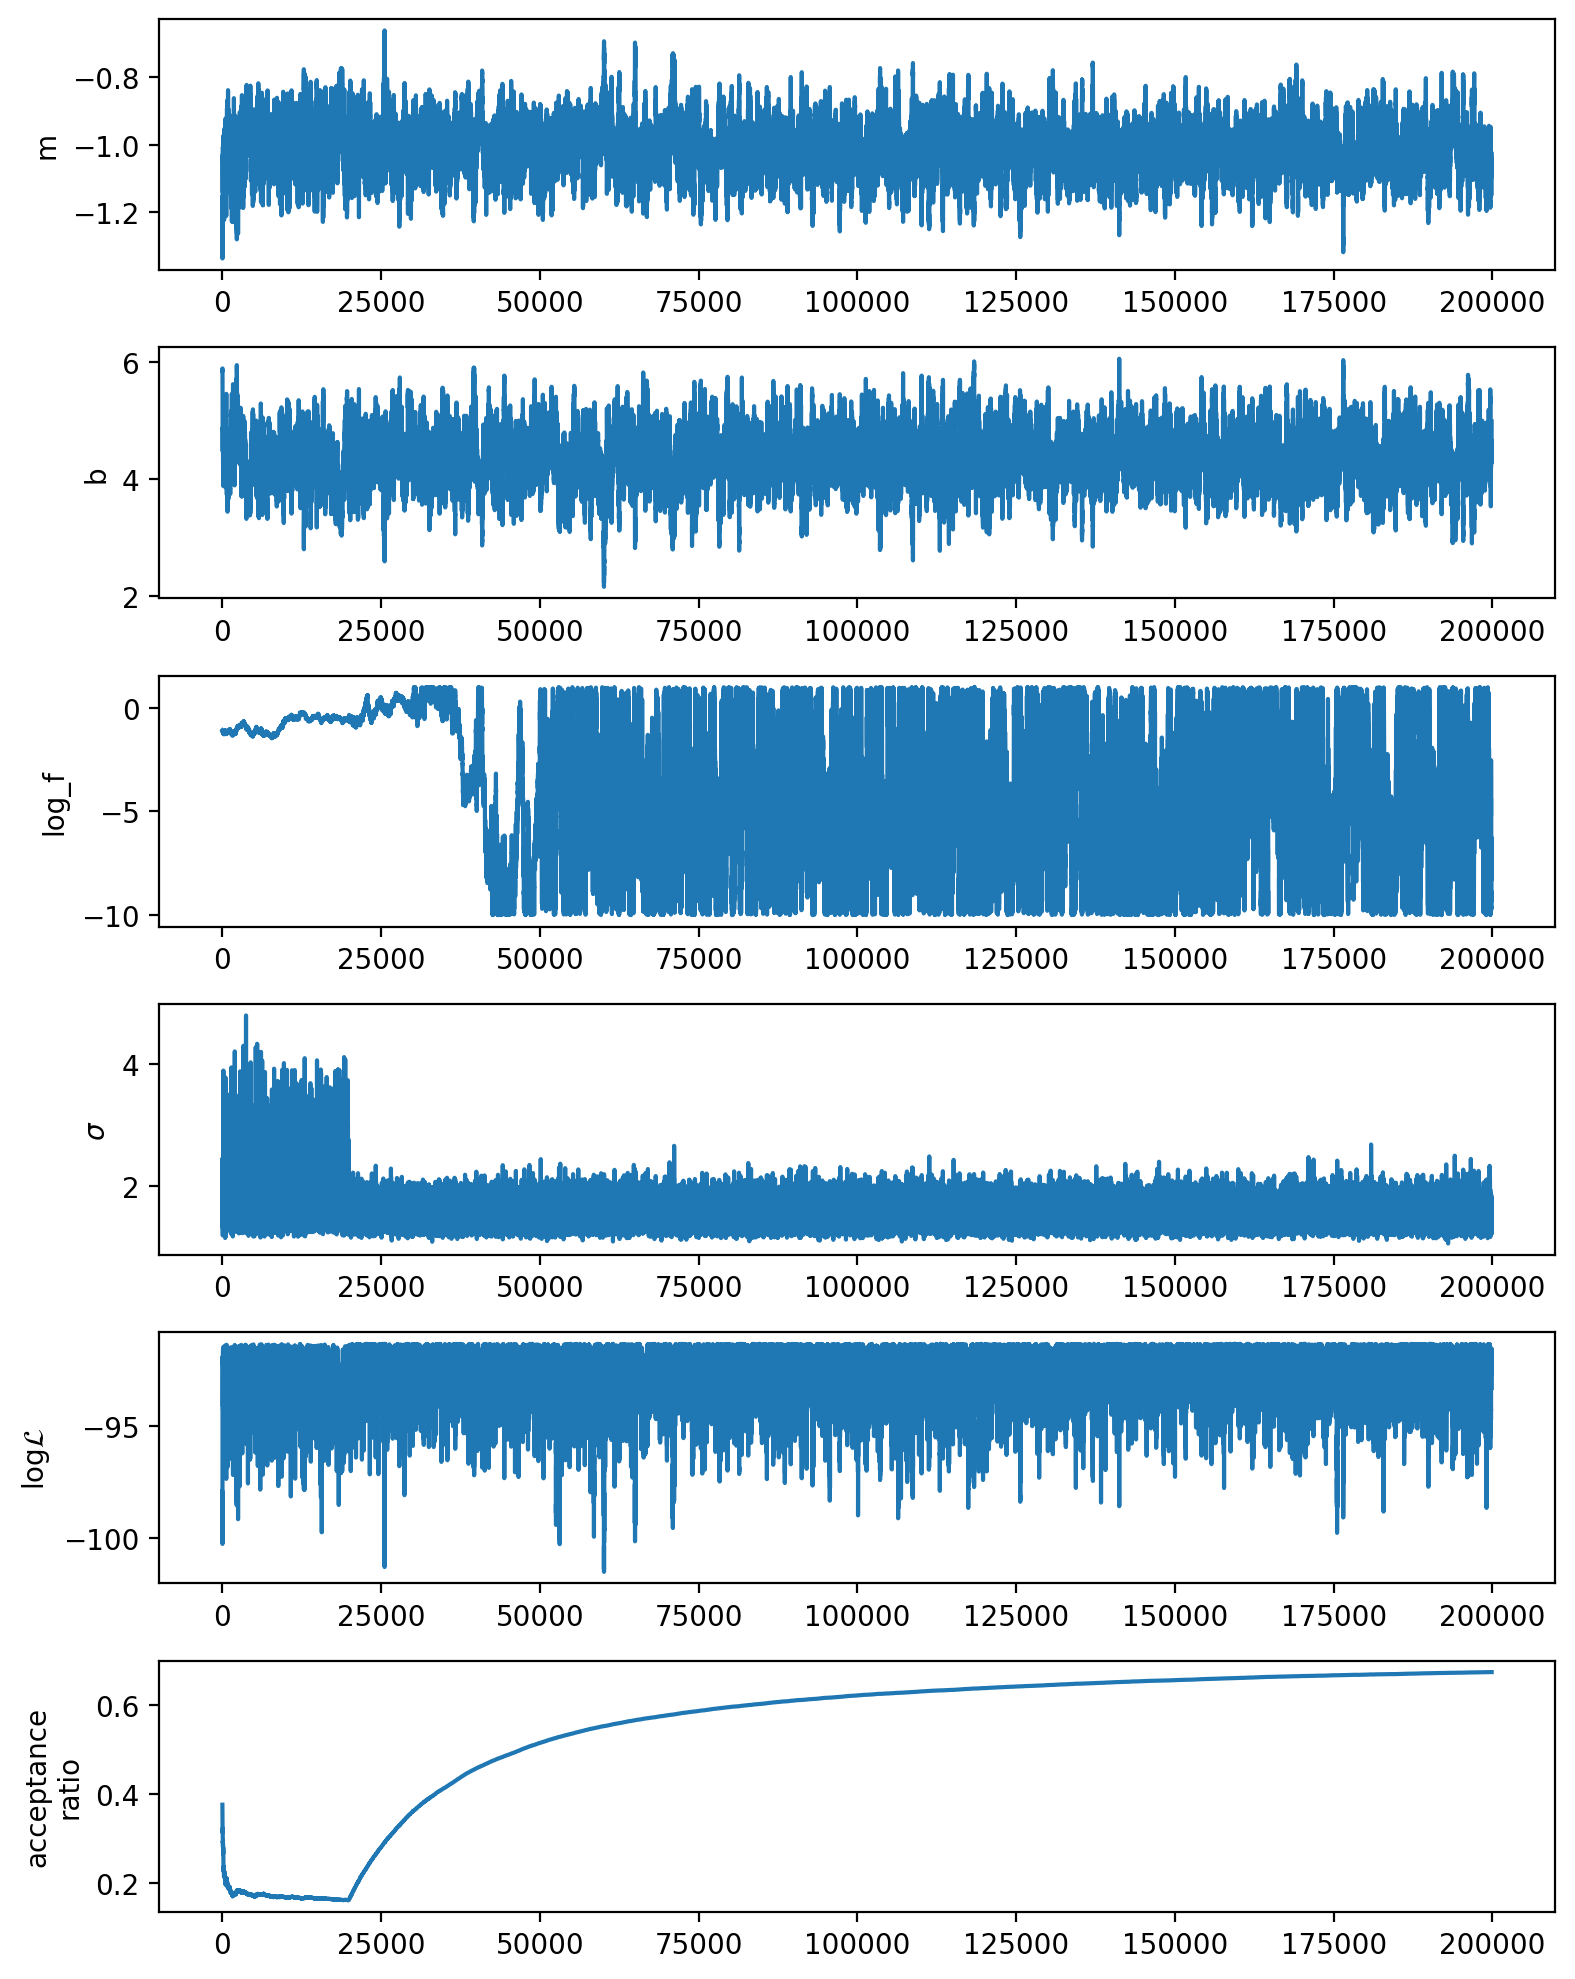

In [53]:
# have a look on the chain
burn = 100
end  = -1
plotChains(M, burn, end)

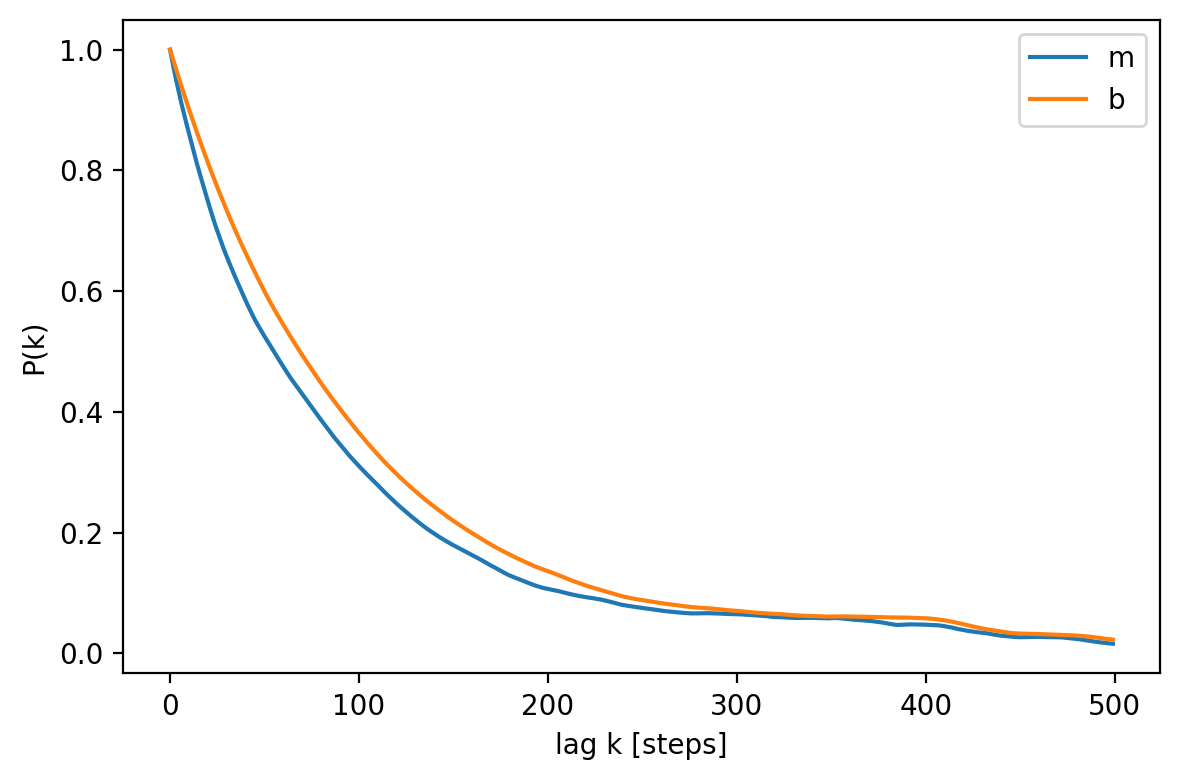

In [54]:
labs = ['m','b','logf']
auto(M.chain, nlag=500, labs=labs)

In [55]:
final_chain = flat_chain_1walker(M.chain,burn=burn, thin=250)
samples = final_chain

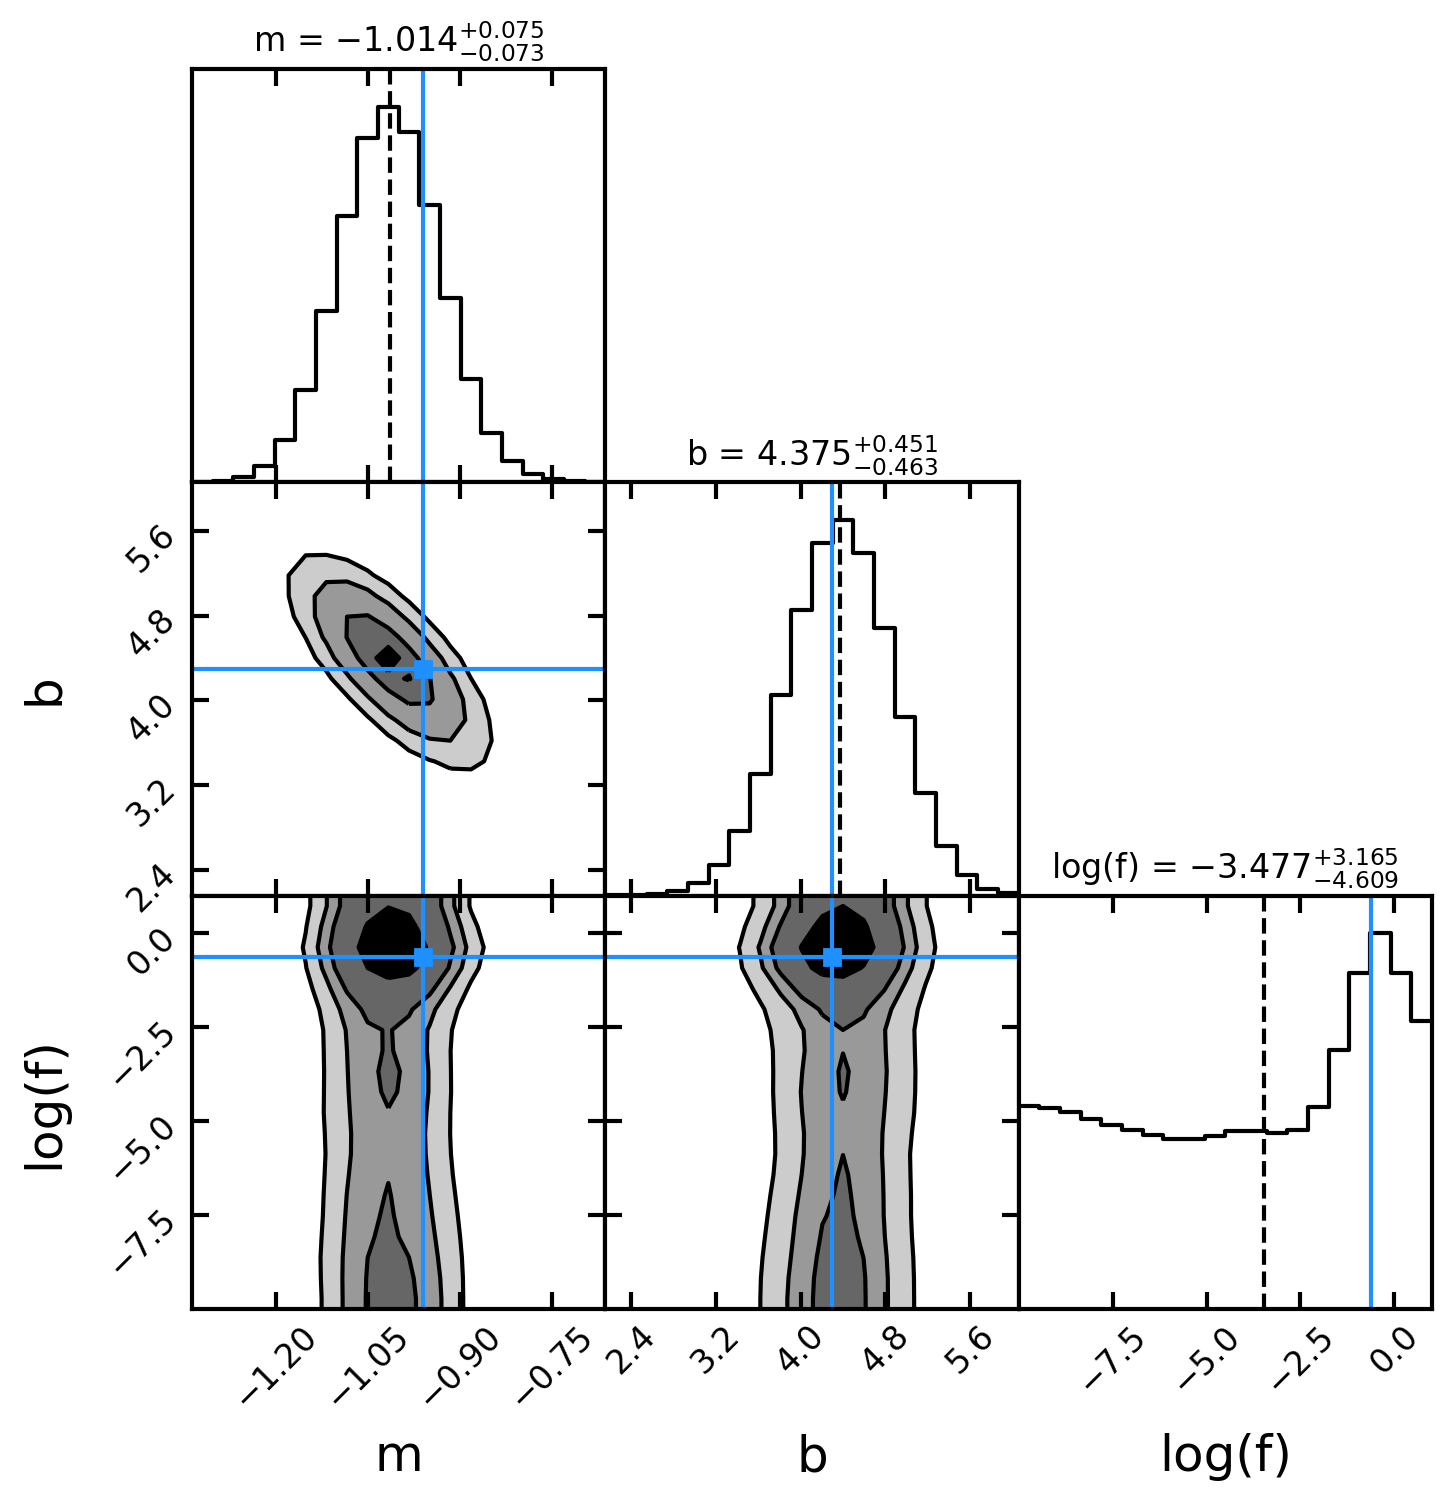

In [56]:
# show corner
labels = ["m", "b", "log(f)"]

fig = corner.corner(\
    M.chain[burn:end,:],\
    truths=[m_true, b_true, np.log(f_true)],\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
